In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image


In [2]:

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = datasets.EuroSAT(root='data', download=True, transform=transform)
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training samples:", len(train_dataset))
print("Testing samples :", len(test_dataset))


100%|██████████| 94.3M/94.3M [00:00<00:00, 411MB/s]


Training samples: 21600
Testing samples : 5400


In [3]:
class EcoVisionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(EcoVisionNet, self).__init__()
        base_model = models.resnet18(pretrained=True)
        for param in base_model.parameters():
            param.requires_grad = False

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.fc1 = nn.Linear(base_model.fc.in_features, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = len(train_data.classes)
model = EcoVisionNet(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


EcoVisionNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total, correct, loss_sum = 0, 0, 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        acc = 100 * correct / total
        print(f"Epoch {epoch+1} | Loss: {loss_sum/len(loader):.4f} | Accuracy: {acc:.2f}%")

train(model, train_loader, epochs=3)


Epoch 1 | Loss: 0.5991 | Accuracy: 80.38%
Epoch 2 | Loss: 0.4161 | Accuracy: 86.03%
Epoch 3 | Loss: 0.3774 | Accuracy: 87.36%


In [5]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print("Test Accuracy:", round(100 * correct / total, 2), "%")


Test Accuracy: 91.15 %


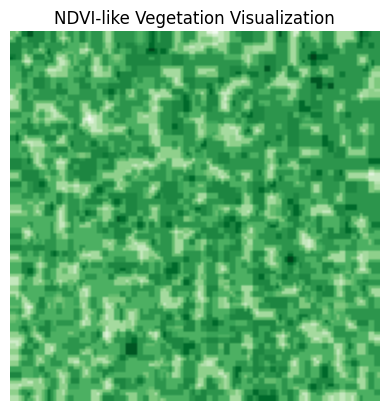

In [6]:
def visualize_ndvi(image_tensor):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    nir_like = image[:, :, 0]
    red_like = image[:, :, 2]
    ndvi = (nir_like - red_like) / (nir_like + red_like + 1e-6)
    plt.imshow(ndvi, cmap='Greens')
    plt.title("NDVI-like Vegetation Visualization")
    plt.axis('off')
    plt.show()

sample_img, _ = train_dataset[random.randint(0, len(train_dataset)-1)]
visualize_ndvi(sample_img)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


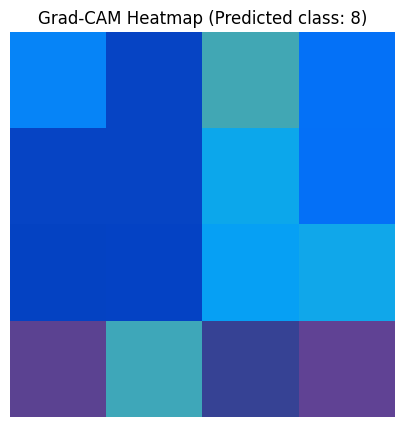

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_gradcam(model, image_tensor):
    model.train()


    image_tensor = image_tensor.unsqueeze(0).to(device)
    image_tensor.requires_grad = True

    activations = None
    gradients = None

    target_layer = None
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            target_layer = layer

    if target_layer is None:
        print(" No Conv2d layer found.")
        return


    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]


    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)


    output = model(image_tensor)
    class_idx = torch.argmax(output, dim=1).item()
    score = output[0, class_idx]
    model.zero_grad()
    score.backward()


    if activations is None or gradients is None:
        print(" Hooks did not capture gradients.")
        fh.remove()
        bh.remove()
        return


    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations[0]
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    fh.remove()
    bh.remove()


    img = image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.title(f"Grad-CAM Heatmap (Predicted class: {class_idx})")
    plt.axis('off')
    plt.show()


generate_gradcam(model, sample_img)


In [14]:
!pip install gradio


In [ ]:
import gradio as gr
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from io import BytesIO
from PIL import Image


class_names = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway",
    "Industrial", "Pasture", "PermanentCrop", "Residential",
    "River", "SeaLake"
]

def generate_gradcam_image(model, image):
    model.eval()
    image = image.resize((64, 64))
    img_arr = np.array(image) / 255.0
    img_tensor = torch.tensor(img_arr).permute(2, 0, 1).unsqueeze(0).float().to(device)
    img_tensor.requires_grad = True

    activations = None
    gradients = None

    target_layer = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            target_layer = module

    if target_layer is None:
        return None, " No Conv2D layer found."

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    output = model(img_tensor)
    class_idx = torch.argmax(output, dim=1).item()
    score = output[0, class_idx]
    model.zero_grad()
    score.backward()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations[0]
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    fh.remove()
    bh.remove()


    heatmap = cv2.resize(heatmap, (img_arr.shape[1], img_arr.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = np.uint8(0.5 * heatmap + 255 * img_arr)


    overlay_img = Image.fromarray(overlay)
    pred_label = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
    return overlay_img, f"Predicted Class: {pred_label}"


In [ ]:
demo = gr.Interface(
    fn=lambda img: generate_gradcam_image(model, img),
    inputs=gr.Image(type="pil", label="Upload Satellite Image"),
    outputs=[
        gr.Image(type="pil", label="Grad-CAM Heatmap"),
        gr.Textbox(label="Prediction")
    ],
    title=" EcoVisionNet - Smart Land Monitoring",
    description="Upload an image to visualize Grad-CAM attention and see model prediction."
)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2562151eb7ba1a7aad.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Created dataset file at: .gradio/flagged/dataset1.csv
